In [1]:
from helpers import *
from plot_helpers import *
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from timer import Timer

In [2]:
index_ = "L10"

In [3]:
size = 10*10
samples = 1000

dtypes = dict([(i, np.int8) for i in range(1,size+1)])
dtypes[0]=np.float32

rawL10 = pd.read_csv("../data/DataBool_C_L10_MCS200000_WT20000.txt", sep=" ", header=None, dtype=dtypes)
# prepare data
X, Y, val_set = base_prepare(rawL10,
                             exportLabels = True,
                             normalize_data = False,
                             select_val_set=True,
                             nsamples=samples,
                             index_=index_,
                             save=False)

In [4]:
# look at data
# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =0.2, shuffle=True)
print("X_train_size: ", X_train.shape)
print("X_test_size: ", X_test.shape)
print("Y_train_size: ", Y_train.shape)
print("Y_test_size: ", Y_test.shape)

X_train_size:  (281740, 100)
X_test_size:  (70436, 100)
Y_train_size:  (281740, 2)
Y_test_size:  (70436, 2)


In [5]:
num_classes = 2
epochs = 100
batch_size = 400

input_shape = (X_train.shape[1],)

In [6]:
# Define Callbacks
# Initializing callbacks
path = f"./model_{index_}.h5"

# Saves the model in-between epochs when there is an improvement in "val_loss"
checkpoint = ModelCheckpoint(path,
                                monitor="val_loss",
                                mode="min",
                                save_best_only = True,
                                verbose=1)

# Stops training the model when no improvement in "val_loss" is observed after set "patience"
earlystop = EarlyStopping(monitor = 'val_loss', 
                              min_delta = 0, 
                              patience = 8,
                              verbose = 1,
                              restore_best_weights = True)

# Monitors "val_loss" for a set 'patience', then the learning rate is reduced by a factor specified manually.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              patience = 4, verbose=1,
                              factor=0.3)


callbacks = [checkpoint, earlystop, reduce_lr]
# callbacks = [checkpoint, reduce_lr]


METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy")
]

In [11]:
model = build_func_model(input_shape, hidden_units=200, l2_reg=0.1, bias_factor=0.001)

model.compile(loss="categorical_crossentropy",optimizer="adam", metrics=METRICS)
history = model.fit(X_train, Y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_test, Y_test), 
                    callbacks=callbacks)

Epoch 1/100
705/705 [==============================] - 12s 13ms/step - loss: 7.1371 - categorical_accuracy: 0.8715 - val_loss: 0.2684 - val_categorical_accuracy: 0.9414

Epoch 00001: val_loss improved from inf to 0.26838, saving model to .\model_L10.h5
Epoch 2/100
705/705 [==============================] - 9s 13ms/step - loss: 0.2604 - categorical_accuracy: 0.9419 - val_loss: 0.2331 - val_categorical_accuracy: 0.9470

Epoch 00002: val_loss improved from 0.26838 to 0.23314, saving model to .\model_L10.h5
Epoch 3/100
705/705 [==============================] - 9s 12ms/step - loss: 0.2326 - categorical_accuracy: 0.9441 - val_loss: 0.2147 - val_categorical_accuracy: 0.9489

Epoch 00003: val_loss improved from 0.23314 to 0.21473, saving model to .\model_L10.h5
Epoch 4/100
705/705 [==============================] - 9s 12ms/step - loss: 0.2176 - categorical_accuracy: 0.9446 - val_loss: 0.2102 - val_categorical_accuracy: 0.9431

Epoch 00004: val_loss improved from 0.21473 to 0.21021, saving mod

705/705 [==============================] - 8s 12ms/step - loss: 0.1477 - categorical_accuracy: 0.9505 - val_loss: 0.1461 - val_categorical_accuracy: 0.9511

Epoch 00068: val_loss did not improve from 0.14614

Epoch 00068: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
Epoch 69/100
705/705 [==============================] - 9s 13ms/step - loss: 0.1446 - categorical_accuracy: 0.9514 - val_loss: 0.1461 - val_categorical_accuracy: 0.9511

Epoch 00069: val_loss improved from 0.14614 to 0.14613, saving model to .\model_L10.h5
Epoch 70/100
705/705 [==============================] - 9s 13ms/step - loss: 0.1459 - categorical_accuracy: 0.9511 - val_loss: 0.1462 - val_categorical_accuracy: 0.9510

Epoch 00070: val_loss did not improve from 0.14613
Epoch 71/100
705/705 [==============================] - 9s 13ms/step - loss: 0.1463 - categorical_accuracy: 0.9511 - val_loss: 0.1461 - val_categorical_accuracy: 0.9510

Epoch 00071: val_loss did not improve from 0.14613
Epoch 72/100

In [12]:
def plot_history(history, metric_names=["categorical_accuracy", "loss"], filename = "", figsize=(20, 7)):
    """
    plot and saves history from model history
    """
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    ax = ax.ravel()
    historyDataFrame = pd.DataFrame()
    metrics = metric_names
    for i, met in enumerate(metrics):
        historyDataFrame[met] = history.history[met]
        historyDataFrame["val_" + met] = history.history["val_" + met]
        ax[i].plot(history.history[met])
        ax[i].plot(history.history["val_" + met])
        ax[i].set_title("Model {}".format(met))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(met)
        ax[i].legend(["train", "val"])
    if filename:
        historyDataFrame.to_csv(filename)

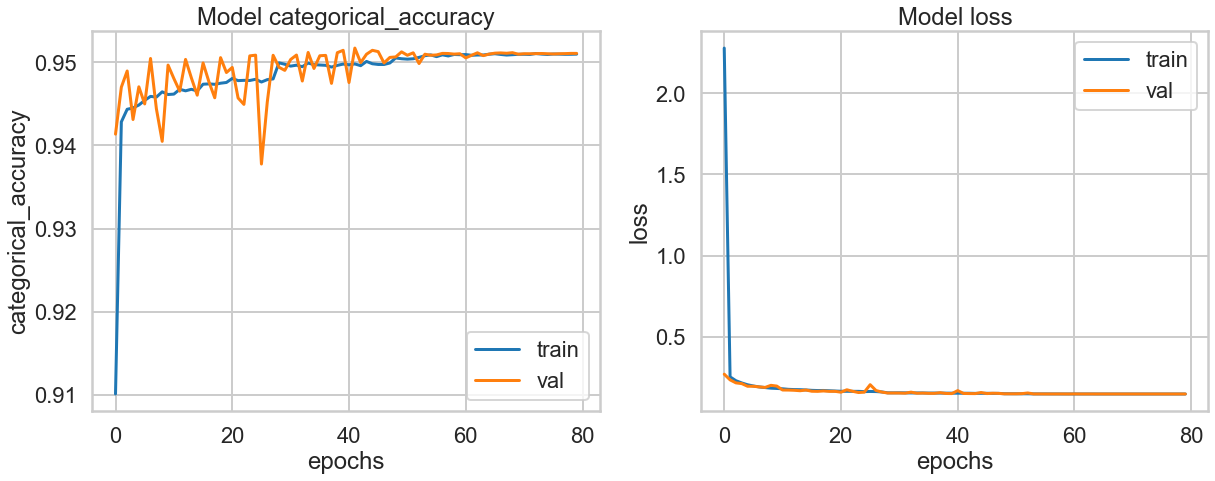

In [13]:
plot_history(history)

In [14]:
val_loss, val_acc = model.evaluate(x=X_test, y=Y_test, batch_size=400, verbose=1)

print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.3f}")

177/177 [==============================] - 2s 9ms/step - loss: 0.1461 - categorical_accuracy: 0.9510
Validation loss: 0.1461
Validation accuracy: 0.951


In [17]:
val_set

,Temperature,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,4.02,1,0,1,1,1,0,1,1,1,...,0,0,0,1,0,0,1,0,0,0
1,4.02,0,1,1,1,0,1,1,1,0,...,1,1,1,1,0,1,0,1,0,1
2,4.02,1,1,1,1,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0
3,4.02,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
4,4.02,1,1,1,1,1,1,1,1,0,...,1,0,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175995,0.52,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
175996,0.52,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
175997,0.52,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
175998,0.52,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [18]:
def generate_predictions(test_df, model, filename, pca=False, batch_size=400, only_mean=True):
    """
    input: test set - dataFrame with Temperature column and LxL columns for configurations
    (one row consists of the Temperature and single spin configuration LxL.
           model - neural network keras model
           filename - str
           only_mean - Boolean - if True, return and saves dataframe with data 
           grouped by temperature and aggregated by mean
    output: new dataframe with the predictions made by model on test_df
    """

    predictions_df = pd.DataFrame(columns=["Temperature", "P_low", "P_high"])
    predictions_df["Temperature"] = test_df["Temperature"]
    if not pca:
        predictions = model.predict(
            test_df.iloc[:,1:].values, batch_size=batch_size, verbose=1
        )
    else:
        predictions = model.predict(
        test_df, batch_size=batch_size, verbose=1
    )
    predictions_df["P_low"] = predictions[:,0]
    predictions_df["P_high"] = predictions[:,1]
    
    if only_mean:
        predictions_df = predictions_df.groupby("Temperature").mean()
    
    predictions_df.to_csv(filename)
    
    return predictions_df


df_pred10 = generate_predictions(val_set, model, f"predictions_{index_}.csv", only_mean=False)

440/440 [==============================] - 1s 2ms/step


# PCA --> 2 components

In [19]:
pca = IncrementalPCA(2)
pca.fit(X_train)

IncrementalPCA(n_components=2)

In [20]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [21]:
X_train_pca = X_train_pca.astype(np.float32)
X_test_pca = X_test_pca.astype(np.float32)

input_shape = (X_train_pca.shape[1],)

model = build_func_model(input_shape, hidden_units=200, l2_reg=0.1, bias_factor=0.001)

model.compile(loss="categorical_crossentropy",optimizer="adam", metrics=METRICS)

# time = Timer()

# time.start()
history = model.fit(X_train_pca, Y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_test_pca, Y_test), 
                    callbacks=callbacks)
# stop = time.stop()

Epoch 1/100
705/705 [==============================] - 8s 10ms/step - loss: 4.0712 - categorical_accuracy: 0.9262 - val_loss: 0.2346 - val_categorical_accuracy: 0.9458

Epoch 00001: val_loss did not improve from 0.14613
Epoch 2/100
705/705 [==============================] - 6s 9ms/step - loss: 0.2273 - categorical_accuracy: 0.9425 - val_loss: 0.2065 - val_categorical_accuracy: 0.9470

Epoch 00002: val_loss did not improve from 0.14613
Epoch 3/100
705/705 [==============================] - 7s 9ms/step - loss: 0.2082 - categorical_accuracy: 0.9439 - val_loss: 0.1949 - val_categorical_accuracy: 0.9463

Epoch 00003: val_loss did not improve from 0.14613
Epoch 4/100
705/705 [==============================] - 7s 9ms/step - loss: 0.1949 - categorical_accuracy: 0.9455 - val_loss: 0.1870 - val_categorical_accuracy: 0.9471

Epoch 00004: val_loss did not improve from 0.14613
Epoch 5/100
705/705 [==============================] - 7s 9ms/step - loss: 0.1867 - categorical_accuracy: 0.9471 - val_loss

705/705 [==============================] - 7s 11ms/step - loss: 0.1458 - categorical_accuracy: 0.9500 - val_loss: 0.1476 - val_categorical_accuracy: 0.9474

Epoch 00038: val_loss did not improve from 0.14464

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 39/100
705/705 [==============================] - 7s 10ms/step - loss: 0.1451 - categorical_accuracy: 0.9504 - val_loss: 0.1433 - val_categorical_accuracy: 0.9505

Epoch 00039: val_loss improved from 0.14464 to 0.14334, saving model to .\model_L10.h5
Epoch 40/100
705/705 [==============================] - 7s 10ms/step - loss: 0.1442 - categorical_accuracy: 0.9512 - val_loss: 0.1433 - val_categorical_accuracy: 0.9507

Epoch 00040: val_loss improved from 0.14334 to 0.14326, saving model to .\model_L10.h5
Epoch 41/100
705/705 [==============================] - 7s 11ms/step - loss: 0.1440 - categorical_accuracy: 0.9506 - val_loss: 0.1436 - val_categorical_accuracy: 0.9505

Epoch 00041: val_loss did n

In [22]:
val_loss, val_acc = model.evaluate(x=X_test_pca, y=Y_test, batch_size=400, verbose=1)

print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.3f}")

177/177 [==============================] - 1s 7ms/step - loss: 0.1417 - categorical_accuracy: 0.9512
Validation loss: 0.1417
Validation accuracy: 0.951


In [24]:
def generate_predictions(test_df, test_df_pca, model, filename, batch_size=400, only_mean=True):
    """
    input: test set - dataFrame with Temperature column and LxL columns for configurations
    (one row consists of the Temperature and single spin configuration LxL.
           model - neural network keras model
           filename - str
           only_mean - Boolean - if True, return and saves dataframe with data 
           grouped by temperature and aggregated by mean
    output: new dataframe with the predictions made by model on test_df
    """

    predictions_df = pd.DataFrame(columns=["Temperature", "P_low", "P_high"])
    predictions_df["Temperature"] = test_df["Temperature"]

    predictions = model.predict(
        test_df_pca, batch_size=batch_size, verbose=1
    )
    predictions_df["P_low"] = predictions[:,0]
    predictions_df["P_high"] = predictions[:,1]
    
    if only_mean:
        predictions_df = predictions_df.groupby("Temperature").mean()
    
    predictions_df.to_csv(filename)
    
    return predictions_df




val_set_pca = pca.transform(val_set.iloc[:,1:]).astype(np.float32)

df_pred10_pca = generate_predictions(val_set, val_set_pca, model, f"predictions_{index_}_PCA.csv", only_mean=False)

440/440 [==============================] - 1s 2ms/step


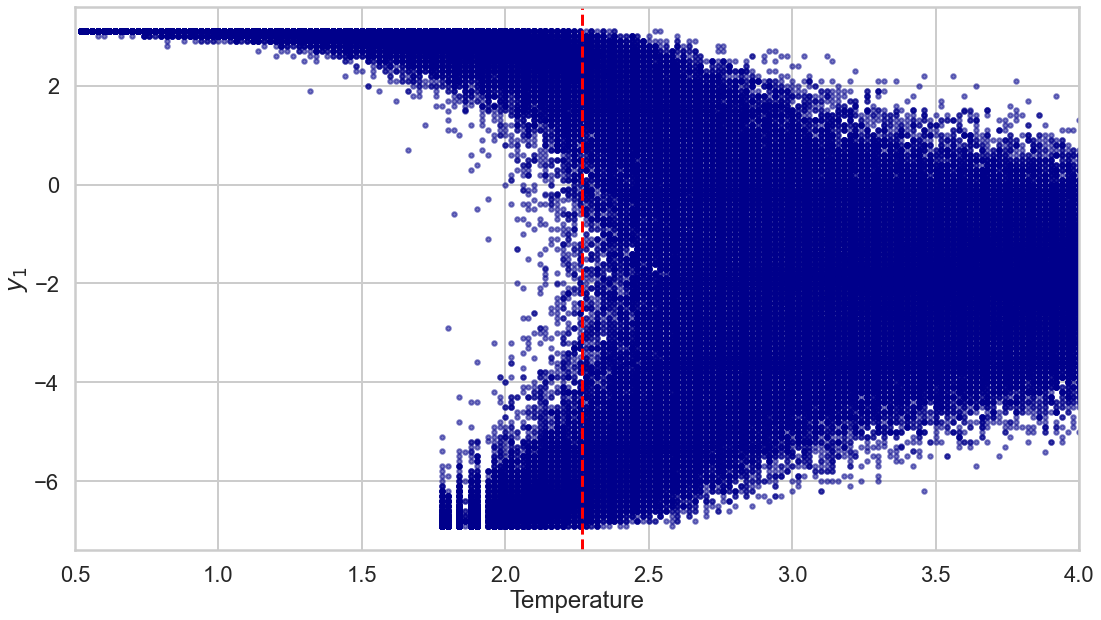

In [25]:
fig, ax = plt.subplots(figsize=(18,10))
ax.scatter(val_set.iloc[:,0], val_set_pca[:,0], s=20, color="darkblue", alpha=0.5)
ax.set_ylabel(r"$y_1$")
ax.set_xlabel("Temperature")
ax.set_xlim([0.5, 4.0])
ax.axvline(2.2669, linestyle="--", color="red")
plt.savefig(f"pca_{index_}_1st_comp_on_temperature.svg", bbox_inches="tight")

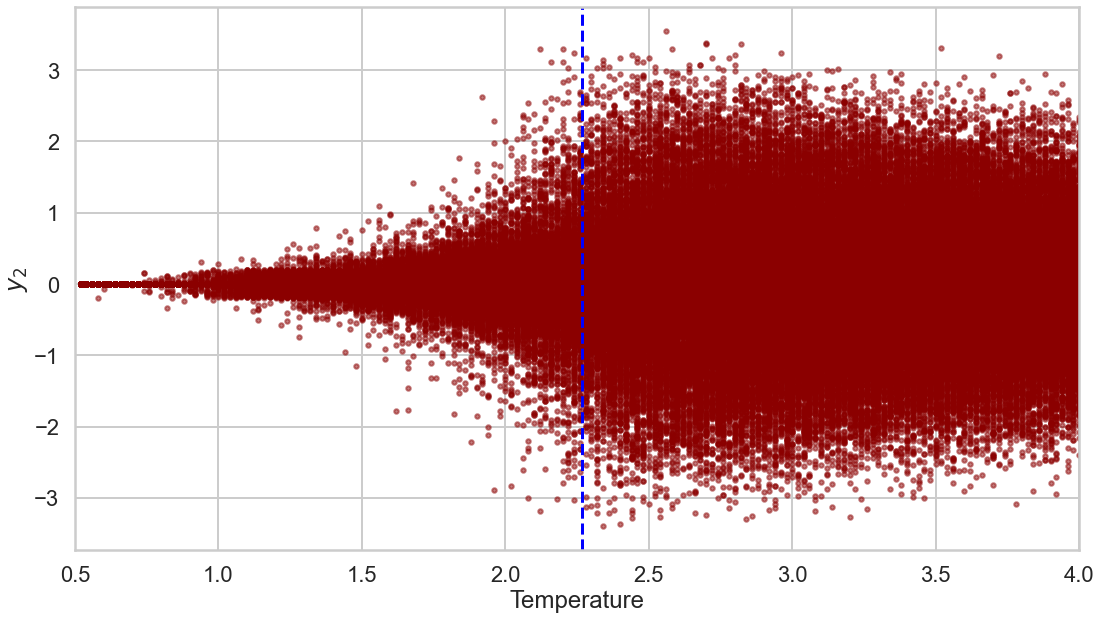

In [26]:
fig, ax = plt.subplots(figsize=(18,10))
ax.scatter(val_set.iloc[:,0], val_set_pca[:,1], s=20, color="darkred", alpha=0.5)
ax.set_ylabel(r"$y_2$")
ax.set_xlabel("Temperature")
ax.set_xlim([0.5, 4.0])
ax.axvline(2.2669, linestyle="--", color="blue")
plt.savefig(f"pca_{index_}_2nd_comp_on_temperature.svg", bbox_inches="tight")

In [27]:
df = pd.DataFrame()
df["Temperature"] = val_set.iloc[:,0]
df["1st component"] = val_set_pca[:,0]
df["2nd component"] = val_set_pca[:,1]
df.to_csv(f"projections_{index_}.csv")

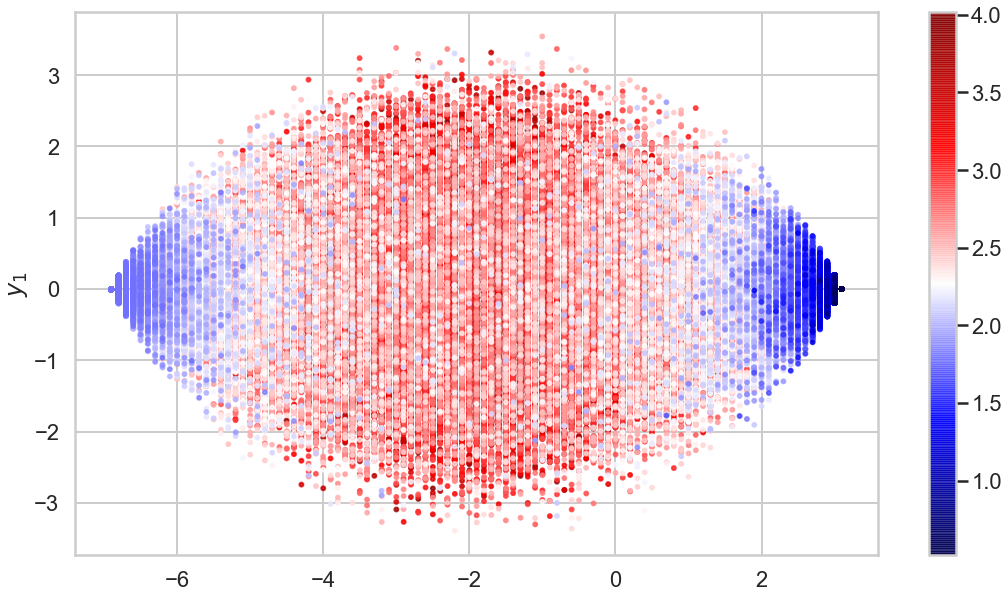

In [29]:
fig, ax = plt.subplots(figsize=(18,10))
p = ax.scatter(df["1st component"], df["2nd component"], c=df["Temperature"], cmap="seismic", s=15, alpha=0.8)
plt.colorbar(p)
ax.set_ylabel(r"$y_2$")
ax.set_ylabel(r"$y_1$")
plt.savefig(f"pca_{index_}_projections.png", bbox_inches="tight")

# PCA 20 components

In [9]:
components = 20


pca20 = IncrementalPCA(components)
pca20.fit(X_train)

X_train_pca20 = pca20.transform(X_train).astype(np.float32)
X_test_pca20 = pca20.transform(X_test).astype(np.float32)

input_shape = (X_train_pca20.shape[1],)

model = build_func_model(input_shape, hidden_units=200, l2_reg=0.1, bias_factor=0.001)

model.compile(loss="categorical_crossentropy",optimizer="adam", metrics=METRICS)

# time = Timer()

# time.start()
history = model.fit(X_train_pca20, Y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_test_pca20, Y_test), 
                    callbacks=callbacks)
# stop = time.stop()



Epoch 1/100
705/705 [==============================] - 6s 8ms/step - loss: 4.8375 - categorical_accuracy: 0.9179 - val_loss: 0.2498 - val_categorical_accuracy: 0.9163

Epoch 00001: val_loss did not improve from 0.14896
Epoch 2/100
705/705 [==============================] - 5s 7ms/step - loss: 0.2302 - categorical_accuracy: 0.9431 - val_loss: 0.2134 - val_categorical_accuracy: 0.9418

Epoch 00002: val_loss did not improve from 0.14896
Epoch 3/100
705/705 [==============================] - 5s 7ms/step - loss: 0.2085 - categorical_accuracy: 0.9440 - val_loss: 0.1946 - val_categorical_accuracy: 0.9486

Epoch 00003: val_loss did not improve from 0.14896
Epoch 4/100
705/705 [==============================] - 5s 7ms/step - loss: 0.1966 - categorical_accuracy: 0.9464 - val_loss: 0.1873 - val_categorical_accuracy: 0.9487

Epoch 00004: val_loss did not improve from 0.14896
Epoch 5/100
705/705 [==============================] - 5s 7ms/step - loss: 0.1887 - categorical_accuracy: 0.9461 - val_loss:

705/705 [==============================] - 5s 8ms/step - loss: 0.1482 - categorical_accuracy: 0.9499 - val_loss: 0.1437 - val_categorical_accuracy: 0.9500

Epoch 00037: val_loss improved from 0.14434 to 0.14372, saving model to .\model_L10.h5
Epoch 38/100
705/705 [==============================] - 5s 7ms/step - loss: 0.1476 - categorical_accuracy: 0.9495 - val_loss: 0.1454 - val_categorical_accuracy: 0.9496

Epoch 00038: val_loss did not improve from 0.14372
Epoch 39/100
705/705 [==============================] - 5s 7ms/step - loss: 0.1470 - categorical_accuracy: 0.9498 - val_loss: 0.1440 - val_categorical_accuracy: 0.9509

Epoch 00039: val_loss did not improve from 0.14372
Epoch 40/100
705/705 [==============================] - 5s 7ms/step - loss: 0.1464 - categorical_accuracy: 0.9498 - val_loss: 0.1451 - val_categorical_accuracy: 0.9511

Epoch 00040: val_loss did not improve from 0.14372
Epoch 41/100
705/705 [==============================] - 5s 7ms/step - loss: 0.1475 - categorical_

705/705 [==============================] - 5s 7ms/step - loss: 0.1420 - categorical_accuracy: 0.9507 - val_loss: 0.1400 - val_categorical_accuracy: 0.9509

Epoch 00071: val_loss improved from 0.14004 to 0.14000, saving model to .\model_L10.h5
Epoch 72/100
705/705 [==============================] - 5s 7ms/step - loss: 0.1404 - categorical_accuracy: 0.9515 - val_loss: 0.1400 - val_categorical_accuracy: 0.9510

Epoch 00072: val_loss improved from 0.14000 to 0.13999, saving model to .\model_L10.h5
Epoch 73/100
705/705 [==============================] - 5s 8ms/step - loss: 0.1410 - categorical_accuracy: 0.9510 - val_loss: 0.1401 - val_categorical_accuracy: 0.9507

Epoch 00073: val_loss did not improve from 0.13999
Epoch 74/100
705/705 [==============================] - 5s 7ms/step - loss: 0.1408 - categorical_accuracy: 0.9511 - val_loss: 0.1400 - val_categorical_accuracy: 0.9509

Epoch 00074: val_loss did not improve from 0.13999
Epoch 75/100
705/705 [==============================] - 5s 7m

In [10]:
val_loss, val_acc = model.evaluate(x=X_test_pca20, y=Y_test, batch_size=400, verbose=1)

print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.3f}")

177/177 [==============================] - 1s 5ms/step - loss: 0.1400 - categorical_accuracy: 0.9510
Validation loss: 0.1400
Validation accuracy: 0.951


In [11]:

val_set_pca = pca20.transform(val_set.iloc[:,1:]).astype(np.float32)



AttributeError: 'numpy.ndarray' object has no attribute 'predict'

In [12]:
def generate_predictions(test_df, test_df_pca, model, filename, batch_size=400, only_mean=True):
    """
    input: test set - dataFrame with Temperature column and LxL columns for configurations
    (one row consists of the Temperature and single spin configuration LxL.
           model - neural network keras model
           filename - str
           only_mean - Boolean - if True, return and saves dataframe with data 
           grouped by temperature and aggregated by mean
    output: new dataframe with the predictions made by model on test_df
    """

    predictions_df = pd.DataFrame(columns=["Temperature", "P_low", "P_high"])
    predictions_df["Temperature"] = test_df["Temperature"]

    predictions = model.predict(
        test_df_pca, batch_size=batch_size, verbose=1
    )
    predictions_df["P_low"] = predictions[:,0]
    predictions_df["P_high"] = predictions[:,1]
    
    if only_mean:
        predictions_df = predictions_df.groupby("Temperature").mean()
    
    predictions_df.to_csv(filename)
    
    return predictions_df

df_pred10_pca = generate_predictions(val_set, val_set_pca, model, f"predictions_{index_}_PCA{components}.csv", only_mean=False)

440/440 [==============================] - 1s 1ms/step


# PCA 70

In [13]:
components = 70

pca70 = IncrementalPCA(components)
pca70.fit(X_train)

X_train_pca70 = pca70.transform(X_train).astype(np.float32)
X_test_pca70 = pca70.transform(X_test).astype(np.float32)

input_shape = (X_train_pca70.shape[1],)

model = build_func_model(input_shape, hidden_units=200, l2_reg=0.1, bias_factor=0.001)

model.compile(loss="categorical_crossentropy",optimizer="adam", metrics=METRICS)

# time = Timer()

# time.start()
history = model.fit(X_train_pca70, Y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_test_pca70, Y_test), 
                    callbacks=callbacks)
# stop = time.stop()


Epoch 1/100
705/705 [==============================] - 5s 6ms/step - loss: 6.1624 - categorical_accuracy: 0.9287 - val_loss: 0.2331 - val_categorical_accuracy: 0.9460

Epoch 00001: val_loss did not improve from 0.13999
Epoch 2/100
705/705 [==============================] - 4s 6ms/step - loss: 0.2276 - categorical_accuracy: 0.9433 - val_loss: 0.2074 - val_categorical_accuracy: 0.9450

Epoch 00002: val_loss did not improve from 0.13999
Epoch 3/100
705/705 [==============================] - 4s 6ms/step - loss: 0.2059 - categorical_accuracy: 0.9454 - val_loss: 0.1959 - val_categorical_accuracy: 0.9461

Epoch 00003: val_loss did not improve from 0.13999
Epoch 4/100
705/705 [==============================] - 5s 7ms/step - loss: 0.1952 - categorical_accuracy: 0.9458 - val_loss: 0.1862 - val_categorical_accuracy: 0.9478

Epoch 00004: val_loss did not improve from 0.13999
Epoch 5/100
705/705 [==============================] - 5s 7ms/step - loss: 0.1888 - categorical_accuracy: 0.9468 - val_loss:

705/705 [==============================] - 8s 12ms/step - loss: 0.1461 - categorical_accuracy: 0.9511 - val_loss: 0.1448 - val_categorical_accuracy: 0.9505

Epoch 00037: val_loss did not improve from 0.13999
Epoch 38/100
705/705 [==============================] - 8s 11ms/step - loss: 0.1478 - categorical_accuracy: 0.9506 - val_loss: 0.1449 - val_categorical_accuracy: 0.9502

Epoch 00038: val_loss did not improve from 0.13999
Epoch 39/100
705/705 [==============================] - 8s 11ms/step - loss: 0.1462 - categorical_accuracy: 0.9510 - val_loss: 0.1447 - val_categorical_accuracy: 0.9506

Epoch 00039: val_loss did not improve from 0.13999

Epoch 00039: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 40/100
705/705 [==============================] - 8s 12ms/step - loss: 0.1457 - categorical_accuracy: 0.9507 - val_loss: 0.1447 - val_categorical_accuracy: 0.9511

Epoch 00040: val_loss did not improve from 0.13999
Epoch 41/100
705/705 [==========================

In [14]:
val_loss, val_acc = model.evaluate(x=X_test_pca70, y=Y_test, batch_size=400, verbose=1)

print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.3f}")

177/177 [==============================] - 1s 5ms/step - loss: 0.1442 - categorical_accuracy: 0.9507
Validation loss: 0.1442
Validation accuracy: 0.951


In [15]:
def generate_predictions(test_df, test_df_pca, model, filename, batch_size=400, only_mean=True):
    """
    input: test set - dataFrame with Temperature column and LxL columns for configurations
    (one row consists of the Temperature and single spin configuration LxL.
           model - neural network keras model
           filename - str
           only_mean - Boolean - if True, return and saves dataframe with data 
           grouped by temperature and aggregated by mean
    output: new dataframe with the predictions made by model on test_df
    """

    predictions_df = pd.DataFrame(columns=["Temperature", "P_low", "P_high"])
    predictions_df["Temperature"] = test_df["Temperature"]

    predictions = model.predict(
        test_df_pca, batch_size=batch_size, verbose=1
    )
    predictions_df["P_low"] = predictions[:,0]
    predictions_df["P_high"] = predictions[:,1]
    
    if only_mean:
        predictions_df = predictions_df.groupby("Temperature").mean()
    
    predictions_df.to_csv(filename)
    
    return predictions_df


val_set_pca = pca70.transform(val_set.iloc[:,1:]).astype(np.float32)

df_pred70_pca = generate_predictions(val_set, val_set_pca, model, f"predictions_{index_}_PCA{components}.csv", only_mean=False)

440/440 [==============================] - 1s 2ms/step
